# Previsão de Engajamento - Classificação

In [1]:
#@title Importações de pacote
import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
BASE_PATH = 'dados/'

# 1 - Carrega os Dados

Carregando dados brutos.

In [3]:
dfx = pd.read_excel(BASE_PATH + 'full-preproc2-inputs.xlsx', index_col='ID')
dfx.head()


,Candidato_Bolsonaro,Candidato_Lula,Dispositivo Retórico,Main character,Retórica Aristotélica,Tipo de conteúdo,Texto / Hashtag,Tonalidade,Abordagem,Duracao,DiasDecorridos
ID,,,,,,,,,,,
7114971700365691904,1,0,Political Statement,Self alone,Pathos,Campaign Act,Hashtag,Neutral,Acclamation,57.93,94
7115050482179050496,1,0,Fact/Statistic,Self alone,Logos,Political-Purposeful,Hashtag,Positive,Acclamation,17.13,94
7115120078982630400,1,0,Commitment,Self + voters,Ethos,Political-Purposeful,Hashtag,Positive,Acclamation,52.54,94
7115161088219565056,1,0,Humor,Self alone,Nenhum,Personal,Hashtag,Positive,Acclamation,34.48,94
7115207919750253568,1,0,Fact/Statistic,Self alone,Logos,Political-Purposeful,Hashtag,Negative,Attack,66.66,94


In [4]:
dfy_full = pd.read_excel(BASE_PATH + 'full-preproc2-outputs.xlsx', index_col='ID')
dfy_full.head()

,Curtidas,Curtidas-Log,Curtidas-MinMax,Curtidas-Log-MinMax,Curtidas-2Classes-75p,Curtidas-2Classes-50p
ID,,,,,,
7114971700365691904,24400,4.387390,0.018396,0.374522,0,0
7115050482179050496,9163,3.962038,0.005674,0.217264,0,0
7115120078982630400,3485,3.542203,0.000933,0.062046,0,0
7115161088219565056,22100,4.344392,0.016476,0.358626,0,0
7115207919750253568,115700,5.063333,0.094630,0.624428,1,1


In [5]:
#df_merged = pd.merge(dfx, dfy_full, on="ID", how="inner")
#df_merged

In [6]:
classes_str = ['NORMAL', 'VIRAL']
dfy = dfy_full['Curtidas-2Classes-75p']
dfy.head()

ID
7114971700365691904    0
7115050482179050496    0
7115120078982630400    0
7115161088219565056    0
7115207919750253568    1
Name: Curtidas-2Classes-75p, dtype: int64

# 2 - Códigos de Preparação

In [7]:
CATEGORICAL_COLS = ['Dispositivo Retórico', 'Main character', 'Retórica Aristotélica', 'Tipo de conteúdo',
                    'Texto / Hashtag', 'Tonalidade', 'Abordagem']

## 2.1 - Transformações

Conjunto de transformações que serão aplicadas nos dados:

In [8]:
#from sklearn.base import clone
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # porque SMOTE não funciona com o Pipeline do scikit-learn

In [9]:
#@title Definições Auxiliares
from sklearn.base import BaseEstimator, TransformerMixin

class Identity(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass

    def fit(self, X):
        return self

    def transform(self, X):
        return X

    def fit_transform(self, X, y=None):
        return X

In [10]:
from imblearn import FunctionSampler

# não pude usar lambda, porque não salva com np.load()
def _identity_sampling_function(X, y):
    return X, y

def identity_sampler():
    fs = FunctionSampler(func=_identity_sampling_function)
    fs._simplified_name = f"IdentitySampler"
    return fs

In [23]:
class TargetEncoderX(TargetEncoder):
    def __init__(self, y_full, **kwargs):
        super().__init__(target_type='continuous', **kwargs)
        self.y_full = y_full

    def fit(self, X, y):
        super().fit(X, self.y_full.loc[y.index])
        return self

    def transform(self, X):
        return super().transform(X)

    def fit_transform(self, X, y):
        return super().fit_transform(X, self.y_full.loc[y.index])

In [24]:
# This is necessary to allow encoding training and/or test data correctly with one-hot encoding
CATEGORIES = [dfx[col].unique() for col in CATEGORICAL_COLS]

def one_hot_encoder(drop_first=True):
   DROP_TYPE = 'first' if drop_first else 'if_binary'
   _transf_o=[
        ('cat', OneHotEncoder(categories=CATEGORIES, drop=DROP_TYPE, sparse_output=False), CATEGORICAL_COLS)]
   ct = ColumnTransformer(transformers=_transf_o, remainder='passthrough')
   ct._simplified_name = f"OneHotEncoder(drop='{DROP_TYPE}')"
   return ct 

def target_encoder_binary():
    _transf_t1=[
        ('cat', TargetEncoder(shuffle=False, target_type='binary'), CATEGORICAL_COLS)]
    ct = ColumnTransformer(transformers=_transf_t1, remainder='passthrough')
    ct._simplified_name = f"TargetEncoder(target_type='binary')"
    return ct 

def target_encoder_continuous(use_log):
    _dfy = dfy_full['Curtidas-Log'] if use_log else dfy_full['Curtidas']
    _transf_t2=[
        ('cat', TargetEncoderX(_dfy, shuffle=False), CATEGORICAL_COLS)]
    ct = ColumnTransformer(transformers=_transf_t2, remainder='passthrough')
    ct._simplified_name = f"TargetEncoderX(target_type='continuous',use_log={use_log})"
    return ct 


In [25]:
from sklearn.base import clone

## 2.2 - Lista de Modelos

In [26]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#from xgboost import XGBClassifier

In [27]:
############ NÃO USADOS ############
[
    {
        "nome_do_modelo": 'Support Vector Machine',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('smote', SMOTE(random_state=42)),
            ('scaler', StandardScaler()), 
            ('predictor', SVC(probability=True))
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(True), one_hot_encoder(False), target_encoder_binary()],
            'smote': [SMOTE(random_state=42,k_neighbors=3), identity_sampler()], 
            'scaler': [Identity(), StandardScaler(), MinMaxScaler()],
            'predictor__C': [0.1, 10, 50],
            #'predictor__gamma': ['scale', 'auto'],
            'predictor__gamma': ['auto'],
            'predictor__kernel': ['linear', 'sigmoid']
            #'predictor__kernel': ['linear', 'rbf', 'sigmoid']
        }
    },
    {
        "nome_do_modelo": 'Decision Tree',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('smote', SMOTE(random_state=42)),
            ('predictor', DecisionTreeClassifier())
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(True), one_hot_encoder(False), target_encoder_binary()],
            'smote': [SMOTE(random_state=42,k_neighbors=3), identity_sampler()],
            'predictor__criterion': ['gini', 'entropy', 'log_loss'],
            'predictor__max_depth': [3, 5, None], 
            'predictor__min_samples_split': [2, 4, 8, 16], 
            'predictor__min_samples_leaf': [1, 2, 4, 8], 
            'predictor__max_features': ['sqrt', 'log2']
        }
    },
    {
        "nome_do_modelo": 'Gradient Boosting',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('smote', SMOTE(random_state=42)),
            ('scaler', StandardScaler()), 
            ('predictor', GradientBoostingClassifier())
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(True), one_hot_encoder(False), target_encoder_binary()],
            'smote': [SMOTE(random_state=42,k_neighbors=3), identity_sampler()],
            'scaler': [Identity(), StandardScaler(), MinMaxScaler()],
            'predictor__n_estimators': [5, 10, 20, 30], 
            'predictor__max_depth': [3, 5, None],
            'predictor__learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5], 
            'predictor__loss': ['log_loss', 'exponential']
        }
    },
    {
        "nome_do_modelo": 'Random Forest',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('smote', SMOTE(random_state=42)),
            ('predictor', RandomForestClassifier())
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(True)], #one_hot_encoder(False), target_encoder_binary()],
            'smote': [SMOTE(random_state=42,k_neighbors=3), identity_sampler()],  # SMOTE(random_state=42),
            'predictor__n_estimators': [10, 20, 40, 60], 
            'predictor__max_depth': [3, 5, None],
            'predictor__min_samples_split': [2, 4, 8, 16],
            'predictor__min_samples_leaf': [1, 2, 4, 8],
            'predictor__max_features': ['sqrt', 'log2']
        }
    },
]

# falta ajustar e testar...
#{
#    "nome_do_modelo": "XGBoost",
#    "estimador": XGBClassifier(),
#    "parametros": {'max_depth': [3, 5, 7]}
#},
#####################################
;

''

In [28]:
lista_modelos = [
    {
        "nome_do_modelo": 'Logistic Regression',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('smote', SMOTE(random_state=42)),
            ('scaler', StandardScaler()), 
            ('predictor', LogisticRegression())
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(True), target_encoder_continuous(False), target_encoder_continuous(True), target_encoder_binary()],    #one_hot_encoder(False), 
            'smote': [SMOTE(random_state=42,k_neighbors=3), identity_sampler()], 
            'scaler': [Identity(), StandardScaler(), MinMaxScaler()],
            'predictor__class_weight': ['balanced'],       # For when SMOTE is not used, adjust weights by class sizes
            'predictor__C': [0.01, 0.1, 1.0, 2.0],   # Regularization parameter
            'predictor__solver': ['saga'],                 # Solver for optimization, saga is the only one to support the 3 options for 'penalty'
            'predictor__penalty': ['l1', 'l2', None]       # Penalty term
        }
    },
    {
        "nome_do_modelo": 'KNN',
        "estimador": Pipeline([
            ('preproc', one_hot_encoder()),
            ('smote', SMOTE(random_state=42)),
            ('scaler', StandardScaler()), 
            ('predictor', KNeighborsClassifier())
        ]),
        "parametros": {
            'preproc': [one_hot_encoder(True), one_hot_encoder(False), target_encoder_binary()],
            'smote': [SMOTE(random_state=42,k_neighbors=3), identity_sampler()],  # SMOTE(random_state=42),
            'scaler': [Identity(), StandardScaler(), MinMaxScaler()],
            'predictor__n_neighbors': [5, 10, 15, 20], 
            'predictor__weights': ['uniform', 'distance'], 
            'predictor__p': [1, 2]
        }
    },

]

# 3 - Treinamento

## 3.1 - Códigos de Treinamento

In [29]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn import metrics

In [30]:
def treinamento_modelo(estimador, X_train, y_train):
    """
    Treina um modelo com os dados de treinamento.

    Args:
        estimador: Um modelo de aprendizado de máquina (classificador/regressor).
        X_train: Dados de treinamento.
        y_train: Rótulos de treinamento.

    Returns:
        estimador_treinado: O modelo treinado.
        tempo_treinamento: O tempo de treinamento em segundos.
    """
    inicio_treinamento = time.time()
    estimador_treinado = estimador.fit(X_train, y_train)
    fim_treinamento = time.time()
    tempo_treinamento = fim_treinamento - inicio_treinamento
    return estimador_treinado, tempo_treinamento

In [31]:
def analise_modelos(lista_modelos, X, y):
    """
    Esta função treina vários modelos e avalia seu desempenho usando métricas como acurácia, precisão, revocação e F1-score.
    Também plota as curvas ROC e PR e a matriz de confusão para cada modelo.

    Args:
        lista_modelos: Uma lista de dicionários contendo informações sobre os modelos a serem treinados.
        X: Conjunto de dados.
        y: Rótulos.

    Returns:
        dict: Um dicionário com as métricas de desempenho de cada modelo e dados dos melhores modelos.
    """

    print(f"\n\n\n **** RESULTADO DOS MODELOS + CURVAS ROC E PR ****\n")

    # Lista para armazenar os valores de fpr e tpr de cada modelo (para a curva ROC)
    roc_fpr_list = []
    roc_tpr_list = []

    # Lista para armazenar os valores de precision e recall de cada modelo (para a curva PR)
    pr_precision_list = []
    pr_recall_list = []
        
    resultados_gerais = {}  # Dicionário para armazenar os resultados desta iteração

    # Configurando a busca em grade dentro de cada iteração da validação cruzada externa
    for mdl in lista_modelos:
        nome_do_modelo = mdl["nome_do_modelo"]
        estimador = mdl.get('estimador')
        parametros = mdl.get('parametros')

        # Listas para armazenar métricas de interesse em cada fold
        accuracy_list = []
        precision_list = []
        recall_list = []
        f1_score_list = []
        auc_score_list = []
        aucpr_score_list = []

        print(f"Treinando modelo {nome_do_modelo} ", end="")

        # Configurando a validação cruzada externa
        cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        # Configurando a busca em grade
        grid_search = GridSearchCV(estimador, parametros, scoring='f1', cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=17), n_jobs=2)
        # testes com 'precision' - resultados ruins

        # Executando a validação cruzada
        tempos_de_treinamento = []
        best_model_params = []
        best_trained_models = []

        for train_ix, test_ix in cv_outer.split(X, y):
            print(".", end="")

            # Separa em dados de treinamento-validação 
            # (obs.: eles serão novamente divididos internamente pelo cv do grid-search)
            X_train, X_test = X.iloc[train_ix], X.iloc[test_ix]  
            y_train, y_test = y.iloc[train_ix], y.iloc[test_ix]

            # Capturando tempo de treinamento
            modelo_treinado, tempo_treinamento = treinamento_modelo(grid_search, X_train, y_train) 
            
            best_model_params.append(modelo_treinado.best_params_)
            best_trained_models.append(clone(modelo_treinado.best_estimator_))
            tempos_de_treinamento.append(tempo_treinamento)

            # IDEIA (será válida?): retreinar com todos os dados, de treinamento-validação (4/5 do total)
            modelo_treinado = grid_search.best_estimator_.fit(X_train, y_train)

            # Avaliação do modelo (com os melhores parâmetros encontrados) no conjunto de teste
            y_pred = modelo_treinado.predict(X_test)
            accuracy = metrics.accuracy_score(y_test, y_pred)
            precisions = metrics.precision_score(y_test, y_pred)
            recalls = metrics.recall_score(y_test, y_pred)
            f1 = metrics.f1_score(y_test, y_pred)

            # Armazenando métricas deste fold
            accuracy_list.append(accuracy)
            precision_list.append(precisions)
            recall_list.append(recalls)
            f1_score_list.append(f1)

            y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]  # Probabilidades da classe positiva
            
            # Calcula auc-ROC
            auc_score = metrics.roc_auc_score(y_test, y_pred_proba)
            auc_score_list.append(auc_score)

            # Valores para a curva ROC
            fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_proba)  # Calcula FPR (false positive rate) e TPR (true positive rate)
            roc_fpr_list.append(fpr)
            roc_tpr_list.append(tpr)

            # Calcula auc-PR
            # https://datascience.stackexchange.com/questions/9003/when-do-i-have-to-use-aucpr-instead-of-auroc-and-vice-versa
            aucpr_score = metrics.average_precision_score(y_test, y_pred_proba)  # Calcula AUC-PR
            aucpr_score_list.append(aucpr_score)

            # Valores para a curva PR
            precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_pred_proba)  # Calcula Precision e Recall
            pr_precision_list.append(precisions)
            pr_recall_list.append(recalls)

        
        print("\n-- coletando e armazenando resultados --\n")

        # Calculando as médias e desvios padrão das métricas
        accuracy_mean = np.mean(accuracy_list)
        accuracy_std = np.std(accuracy_list)
        precision_mean = np.mean(precision_list)
        precision_std = np.std(precision_list)
        recall_mean = np.mean(recall_list)
        recall_std = np.std(recall_list)
        f1_score_mean = np.mean(f1_score_list)
        f1_score_std = np.std(f1_score_list)

        auc_mean = np.mean(auc_score_list)
        auc_std = np.std(auc_score_list)
        aucpr_mean = np.mean(aucpr_score_list)
        aucpr_std = np.std(aucpr_score_list)

        #print(f" - Modelo     : {nome_do_modelo}")
        print(f" - Acurácia   : {accuracy_mean:.4f} +/- {accuracy_std:.5f}")
        print(f" - Precisão   : {precision_mean:.4f} +/- {precision_std:.5f}")
        print(f" - Revocação  : {recall_mean:.4f} +/- {recall_std:.5f}")
        print(f" - F1 - Score : {f1_score_mean:.4f} +/- {f1_score_std:.5f}")
        print(f" - ROC - AUC  : {auc_mean:.4f} +/- {auc_std:.5f}")
        print(f" - PR - AUC   : {aucpr_mean:.4f} +/- {aucpr_std:.5f}")
        print(f" - Tempo médio de treinamento: {np.mean(tempos_de_treinamento):.2f} segundos\n")
        print('=' * 50, '\n')

        #resultados_iteracao[mdl.get('nome_do_modelo')]  = {
        resultados_gerais[nome_do_modelo]  = {
            "Acurácia_mean": accuracy_mean,
            "Acurácia_std": accuracy_std,
            "Precisão_mean": precision_mean,
            "Precisão_std": precision_std,
            "Revocação_mean": recall_mean,
            "Revocação_std": recall_std,
            "F1_score_mean": f1_score_mean,
            "F1_score_std": f1_score_std,
            "aucROC_mean": auc_mean,
            "aucROC_std": auc_std,
            "aucPR_mean": aucpr_mean,
            "aucPR_std": aucpr_std,
            "tempo_medio_treinamento": np.mean(tempos_de_treinamento),
            "F1_score_list": f1_score_list,
            "melhores_parametros": best_model_params, 
            "melhores_modelos": best_trained_models 
        }

        # CRIAR UM ENSEMBLE MISTURANDO TIPOS DE MODELOS DISTINTOS
        # E/OU CRIAR UM ENSEMBLE COM TODAS VERSÔES DE UM MESMO MODELO??

    # Tentar fazer em função à parte, com os dados salvos nos resultados
    # Depois de treinar todos os modelos:

    # Plota a curva ROC geral
    plt.figure(figsize=(10, 8)) 
    for fpr, tpr, mdl in zip(roc_fpr_list, roc_tpr_list, lista_modelos):
        plt.plot(fpr, tpr, label='%s ROC' % mdl["nome_do_modelo"])
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('CURVA ROC')
    plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0))  # Posiciona a legenda
    plt.show()

    # Plota a curva PR geral - não sei se está correta
    # ver https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    # Ideia: plotar a média das curvas PR
    '''plt.figure(figsize=(10, 8))
    for precisions, recalls, mdl in zip(pr_precision_list, pr_recall_list, lista_modelos):
        plt.plot(recalls, precisions, label='%s PR' % mdl["nome_do_modelo"])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('CURVA PR')
    plt.legend(loc='lower right', bbox_to_anchor=(1.5, 0))  # Posiciona a legenda
    plt.show()'''

    return resultados_gerais

In [32]:
# função para salvar os resultados e os parâmetros dos modelos
def save_results(filename, resultados, description):
    np.save(filename, [description, resultados], allow_pickle=True)

In [33]:
# função para carregar os resultados e os parâmetros dos modelos
def load_results(filename):
    description, r = np.load(filename, allow_pickle=True)
    print("Carregado arquivo de resultados com descrição:")
    print(description)
    return r

## 3.2 - Chamada Principal




 **** RESULTADO DOS MODELOS + CURVAS ROC E PR ****

Treinando modelo Logistic Regression .

....
-- coletando e armazenando resultados --

 - Acurácia   : 0.6572 +/- 0.05162
 - Precisão   : 0.3735 +/- 0.06286
 - Revocação  : 0.5483 +/- 0.11241
 - F1 - Score : 0.4428 +/- 0.07811
 - ROC - AUC  : 0.6760 +/- 0.05660
 - PR - AUC   : 0.4633 +/- 0.06501
 - Tempo médio de treinamento: 41.02 segundos


Treinando modelo KNN .....
-- coletando e armazenando resultados --

 - Acurácia   : 0.6133 +/- 0.03941
 - Precisão   : 0.3622 +/- 0.02679
 - Revocação  : 0.7047 +/- 0.04944
 - F1 - Score : 0.4770 +/- 0.02271
 - ROC - AUC  : 0.6772 +/- 0.04583
 - PR - AUC   : 0.4109 +/- 0.05163
 - Tempo médio de treinamento: 49.90 segundos




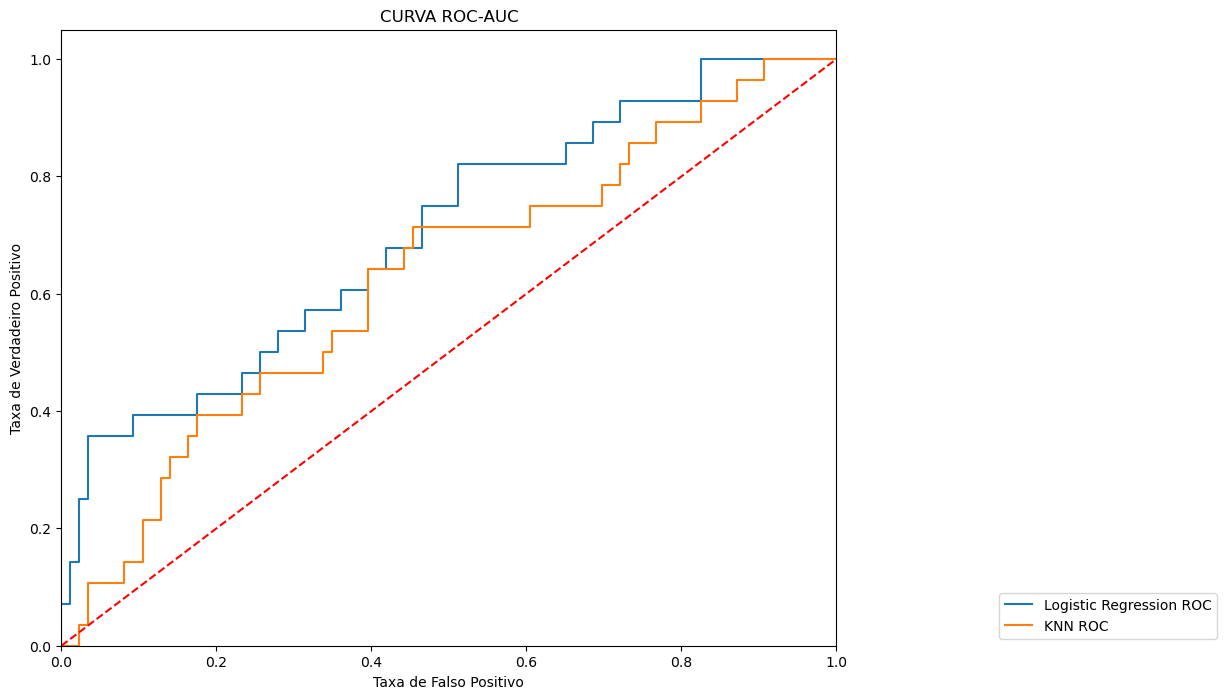

In [34]:
result = analise_modelos(lista_modelos, dfx, dfy)

In [35]:
description = "Primeiro treinamento com modelos com os novos dados desbalanceados (75p), com o dataset geral (lula e bolsonaro)."
save_results('./resultados/resultados_2024-04-30_full.npy', result, description)

In [36]:
#load_results('./resultados/resultados_2024-04-30_full.npy')

# 4. Análise dos Resultados

In [37]:
MODEL_NAMES = [mdl["nome_do_modelo"] for mdl in lista_modelos]

In [38]:
from ipywidgets import interact

In [39]:
METRICS = ['Acurácia_mean', 'Precisão_mean', 'Revocação_mean', 'F1_score_mean', 'aucROC_mean', 'aucPR_mean']

In [40]:
df_result = pd.DataFrame(result).T
df_result = df_result[METRICS]

In [48]:
def order_models_by(order_by):
    display(df_result.sort_values(by=order_by, ascending=False))
    return

interact(order_models_by, order_by=METRICS);

interactive(children=(Dropdown(description='order_by', options=('Acurácia_mean', 'Precisão_mean', 'Revocação_m…

## 4.1 - Melhores Hiper-Parâmetros

In [42]:
from collections import Counter

def aggregate_best_params(model_name):
    best_params_list = result[model_name]['melhores_parametros']
    
    # for each name of parameter, counts the number of times each of its value appeared among the best
    params_count = dict()

    for param_name in best_params_list[0].keys():
        # fora each value of the parameter, counts the occurences
        params_count[param_name] = Counter()
        
        for params in best_params_list:
            if param_name == 'preproc':
                param_value = params[param_name]._simplified_name
            else:
                param_value = params[param_name]
            params_count[param_name][param_value] += 1
    
    display(params_count)

#aggregate_best_params('Logistic Regression')
interact(aggregate_best_params, model_name=MODEL_NAMES)

interactive(children=(Dropdown(description='model_name', options=('Logistic Regression', 'KNN'), value='Logist…

<function __main__.aggregate_best_params(model_name)>

In [43]:
def list_all_best_params(model_name):
    best_params_list = result[model_name]['melhores_parametros']
    for i, paramset in enumerate(best_params_list):
        print("BEST PARAM SET", i, ":")
        for key in paramset.keys():
            if key == 'preproc':
                print(f" - {key}: {paramset[key]._simplified_name}")
            else:
                print(f" - {key}: {paramset[key]}")
        print(f" - F1 score: {result[model_name]['F1_score_list'][i]:.4f}")


list_all_best_params('Logistic Regression')
#list_all_best_params('Random Forest')

BEST PARAM SET 0 :
 - predictor__C: 0.1
 - predictor__class_weight: balanced
 - predictor__penalty: l2
 - predictor__solver: saga
 - preproc: TargetEncoderX(target_type='continuous',use_log=False)
 - scaler: StandardScaler()
 - smote: SMOTE(k_neighbors=3, random_state=42)
 - F1 score: 0.4194
BEST PARAM SET 1 :
 - predictor__C: 0.01
 - predictor__class_weight: balanced
 - predictor__penalty: l2
 - predictor__solver: saga
 - preproc: TargetEncoderX(target_type='continuous',use_log=False)
 - scaler: StandardScaler()
 - smote: FunctionSampler(func=<function _identity_sampling_function at 0x0000028166E0AD40>)
 - F1 score: 0.4000
BEST PARAM SET 2 :
 - predictor__C: 2.0
 - predictor__class_weight: balanced
 - predictor__penalty: l1
 - predictor__solver: saga
 - preproc: TargetEncoderX(target_type='continuous',use_log=False)
 - scaler: StandardScaler()
 - smote: FunctionSampler(func=<function _identity_sampling_function at 0x0000028166E0AD40>)
 - F1 score: 0.5946
BEST PARAM SET 3 :
 - predicto

## 4.2 - Importância dos Atributos


- Baseado nos valores de `feature_importances_` calculados em alguns modelos

In [44]:
#@title Definições auxiliares (não precisa abrir)
from sklearn.tree import plot_tree
import numpy as np
import matplotlib.pyplot as plt

def plot_importance(model, title=None, max_features=None, feature_names=None, sort=True, ax=None):
    """
    Plot feature importances for a scikit-learn random forest or gradient boosting model.

    Parameters
    ----------
    model : object
        A scikit-learn random forest or gradient boosting model.
    title: str or None, optional (default=None)
        The title of the plot.
    max_features : int or None, optional (default=None)
        The maximum number of features to plot. If None, plot all features.
    feature_names : list or None, optional (default=None)
        A list of feature names to use in the plot. If None, use the feature indices.
    sort : bool, optional (default=True)
        Whether to sort the feature importances in descending order.
    ax : matplotlib.axes.Axes or None, optional (default=None)
        The matplotlib axes to plot the feature importances on. If None, create a new figure and axes.

    Returns
    -------
    ax : matplotlib.axes.Axes
        The matplotlib axes containing the plot.

    """
    # Extract feature importances
    importances = model.feature_importances_

    # Get feature names
    if feature_names is None:
        feature_names = [str(i) for i in range(len(importances))]

    # Sort feature importances
    if sort:
        indices = np.argsort(importances)[::-1]
        importances = importances[indices]
        feature_names = [feature_names[i] for i in indices]

    # Truncate feature importances
    if max_features is not None:
        importances = importances[:max_features]
        feature_names = feature_names[:max_features]

    # Create plot
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        ax.set_title(title)
    ax.barh(np.arange(len(importances)), importances, align='center')
    ax.set_yticks(np.arange(len(importances)))
    ax.set_yticklabels(feature_names)
    ax.set_xlabel('Feature importance')
    ax.invert_yaxis()

    return ax

In [45]:
if 'Decision Tree' in result:
    # best model of the 1st fold of the outer cross-validation
    dec_tree_pipeline = result['Decision Tree']['melhores_modelos'][0]

    # fit the pipeline to the WHOLE dataset
    dec_tree_pipeline.fit(dfx, dfy)

    display(dec_tree_pipeline)
    
    # the decision tree model inside the pipeline
    dec_tree = dec_tree_pipeline.named_steps['predictor']
    feature_names = dec_tree_pipeline.named_steps['preproc'].get_feature_names_out()

    fig = plt.figure(figsize=(22,15))
    plot_tree(dec_tree, feature_names=list(feature_names), filled=True);

In [46]:
for model_name in result.keys():
    model_pipeline = result[model_name]['melhores_modelos'][0]  # the best model found in the first fold
    model_predictor = model_pipeline.named_steps['predictor']

    model_pipeline.fit(dfx, dfy)  # fit the pipeline to the WHOLE dataset

    # testa se o modelo guarda as importâncias das features
    if not hasattr(model_predictor, 'feature_importances_'):
        print(f"O modelo {model_name} não registra as importâncias das features")
        continue
    features = model_pipeline.named_steps['preproc'].get_feature_names_out()
    plot_importance(model_predictor, title=f"Importância das features no modelo {model_name}", feature_names=features, max_features=20)

O modelo Logistic Regression não registra as importâncias das features
O modelo KNN não registra as importâncias das features
